<a href="https://colab.research.google.com/github/SeongJae999/AIFFEL_quest_cr/blob/main/Exploration/Sub%20Quest%20C24/chanxxw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 6-1. 프로젝트: 인물 모드 문제점 찾기
만들면서 뭔가 이상한 점이 느껴지지 않으셨나요? 프로젝트를 통해 찾아봅시다.

#### Step 1. 인물모드 직접 해 보기  
여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.  
인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.  
배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?


In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from transformers import AutoProcessor, AutoModelForImageSegmentation


Image loaded: 2.jpg, Size: (590, 590), Format: JPEG
Image loaded: 1.jpg, Size: (1086, 1442), Format: JPEG
Image loaded: 3.jpg, Size: (4032, 3024), Format: JPEG


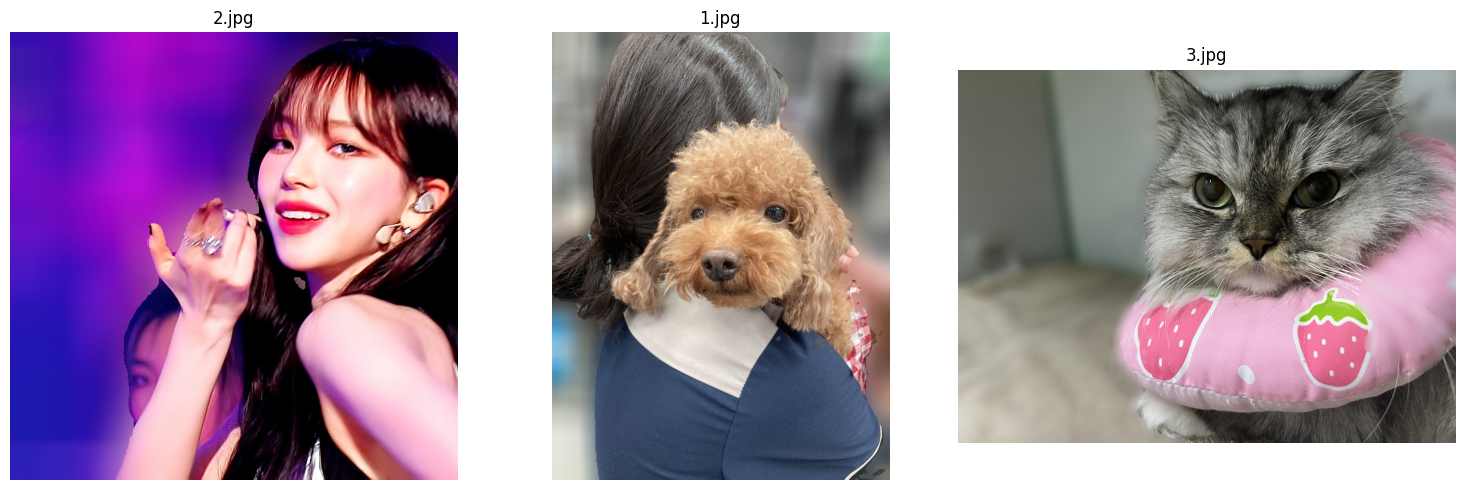

In [ ]:

# 불러올 이미지 파일 경로들
image_paths = ["2.jpg", "1.jpg", "3.jpg"]  # 예: ["1.jpg", "2.jpg", "3.jpg"]

# 이미지 열기
images = []
for path in image_paths:
    try:
        img = Image.open(path)
        images.append(img)
        print(f"Image loaded: {path}, Size: {img.size}, Format: {img.format}")
    except Exception as e:
        print(f"Failed to load {path}: {e}")

# 여러 이미지를 동시에 표시
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))  # 1행, len(images)열
for ax, img, path in zip(axes, images, image_paths):
    ax.imshow(img)
    ax.axis("off")  # 축 제거
    ax.set_title(path)

plt.tight_layout()
plt.show()

### Step 2. 사진에서 문제점 찾기
그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.  

아래 사진에도 문제점이 몇 가지 있었습니다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.  

추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.  

## 문제점 찾은 것
- 2.jpg : 뒤에 있는 사람이 같이 나옴.(근데 instance 아니니 상관 없는건가?)
- 1.jpg : 사람 손이 blur 처리됨
- 3.jpg : 고양이 목에 있는 천넥카라가 일부 blur 처리됨
- (개인 사진으로 했을 때) 가로세로 문제로 진행이 안되는 일이 있었음.

### Step 3. 해결 방법을 제안해 보기
아주 간단히 멋진 카메라 앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금 같은 완성도로는 어림도 없습니다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.

생각해 볼 만한 주제를 아래에 몇 가지 제시해 봅니다. 아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.
단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.

#### 세그멘테이션의 한계
- Semantic segmentation의 부정확성이 여러 가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라 한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.

#### 피사계 심도 이해하기
- 우선 피사계심도의 개념부터 명확히 이해해 봅시다.
- https://m.blog.naver.com/typs6301/222172333739
- https://www.adobe.com/kr/creativecloud/photography/discover/shallow-depth-of-field.html

#### 3D Camera 활용하기
- 이미지를 2D 방식으로 받아들이는 한계를 넘어 3D로 인식하려는 시도는 꽤 오래전부터 계속되어 왔습니다. 기술도 이제는 상당한 수준에 이르렀는데요. 크게는 스테레오 비전, ToF 방식 등이 자주 사용됩니다. 하드웨어 이미지 센서를 통한 3D 이미징 기술이 많이 발전되었는데요. 아래 참고 자료를 통해 최신 기술을 살펴봐도 좋습니다.
- https://news.skhynix.co.kr/post/next-gen-3d

#### 소프트웨어 기술 활용하기
- 하드웨어 개발과 생산에는 비용이 많이 들기 때문에 제한된 하드웨어를 이용하면서 소프트웨어로 그 한계를 극복하려는 노력도 많습니다. 구글의 struct2Depth가 대표적인 예일 것 같습니다.
- https://sites.google.com/view/struct2depth
- 딥러닝이 발전한 지금은 더 다양한 기술이 개발되어 있으니 잘 탐색해 보세요.

#### 다른 기술과 융합해 보기
- 구글 pixel4에는 IR(적외선) 카메라가 달려있는데요. 물체의 온도를 측정하는 IR 카메라와 3D 이미지는 크게 관련이 없을 것 같지만, 이를 통해 보다 멋진 3d depth sensing이 가능하다는군요.  
- https://research.google/blog/udepth-real-time-3d-depth-sensing-on-the-pixel-4/  

-----

In [ ]:
!pip install kornia

In [ ]:
# GPU가 사용 가능한지 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 모델 로드
model = AutoModelForImageSegmentation.from_pretrained('briaai/RMBG-2.0', trust_remote_code=True)

# 연산 속도 최적화 설정
torch.set_float32_matmul_precision(['high', 'highest'][0])

# 모델을 선택된 디바이스로 이동
model.to(device)
model.eval()

print(f"Model loaded on {device}. Ready for inference.")


Using device: cpu


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

BiRefNet_config.py:   0%|          | 0.00/298 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/briaai/RMBG-2.0:
- BiRefNet_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


birefnet.py:   0%|          | 0.00/91.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/briaai/RMBG-2.0:
- birefnet.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


model.safetensors:   0%|          | 0.00/885M [00:00<?, ?B/s]

Model loaded on cpu. Ready for inference.


In [ ]:
def transform_image(image):
    # Convert RGBA to RGB if image has alpha channel
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    image_size = (1024, 1024)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    return transform(image)

# Usage
input_image_path = "/content/aiffel.jpg"
image = Image.open(input_image_path)
print(image.size)
input_images = transform_image(image).unsqueeze(0).to('cpu')

(1280, 720)


In [ ]:
# Prediction
with torch.no_grad():
    preds = model(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()
pred_pil = transforms.ToPILImage()(pred)
mask = pred_pil.resize(image.size)
image.putalpha(mask)

image.save("no_bg_image.png")

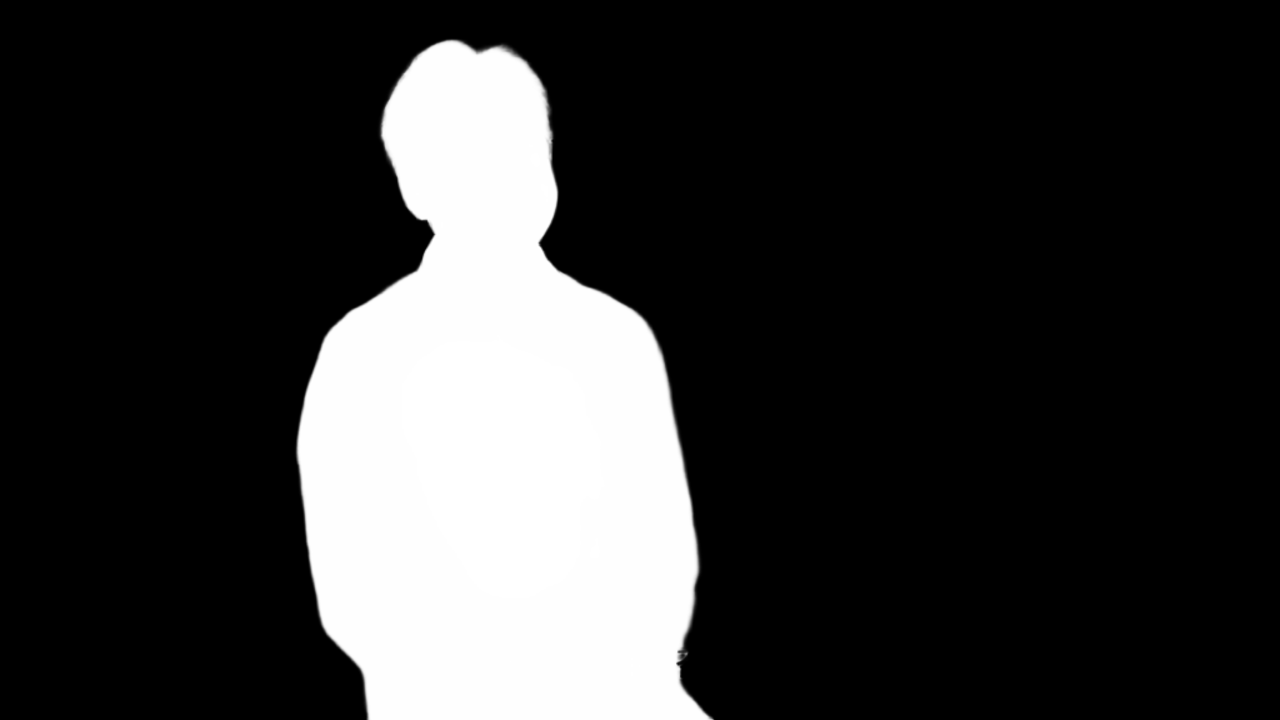

In [ ]:
mask

(720, 1280, 3)


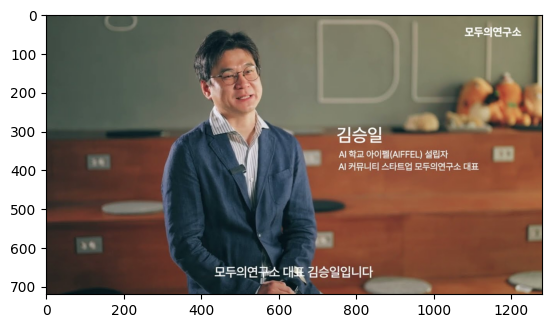

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_orig = cv2.imread(input_image_path)

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

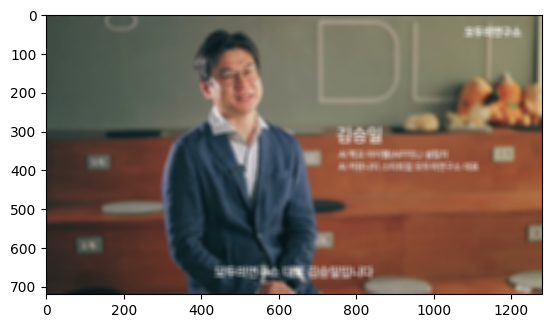

In [ ]:
img_blurred = cv2.blur(img_orig, (13, 13))

plt.imshow(cv2.cvtColor(img_blurred, cv2.COLOR_BGR2RGB))
plt.show()

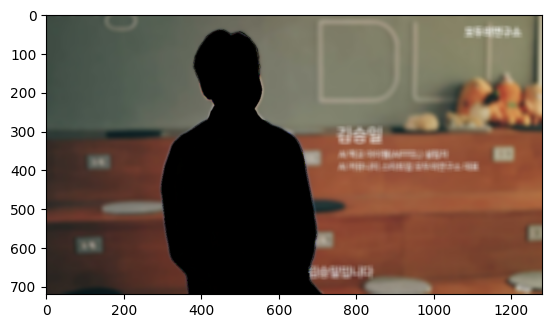

In [ ]:
import numpy as np

np_mask = np.array(mask)

img_mask_color = cv2.cvtColor(np_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_blurred, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
np.unique(img_mask_color)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

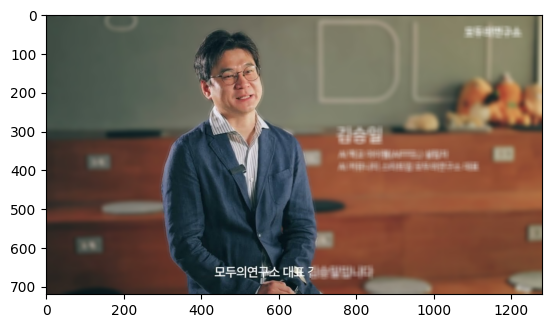

In [ ]:
img_concat = np.where(img_mask_color>0, img_orig, img_blurred)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

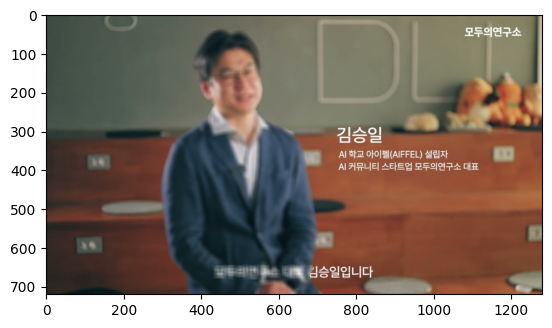

In [ ]:
img_concat = np.where(img_mask_color==0, img_orig, img_blurred)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
from transformers import AutoProcessor, AutoModelForImageSegmentation
from PIL import Image
import numpy as np

# GPU가 사용 가능한지 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 모델 로드
model = AutoModelForImageSegmentation.from_pretrained('briaai/RMBG-2.0', trust_remote_code=True)

# 연산 속도 최적화 설정
torch.set_float32_matmul_precision(['high', 'highest'][0])

# 모델을 선택된 디바이스로 이동
model.to(device)
model.eval()

print(f"Model loaded on {device}. Ready for inference.")


def transform_image(image):
    # Convert RGBA to RGB if image has alpha channel
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    image_size = (1024, 1024)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    return transform(image)

# Usage
input_image_path = "/content/aiffel.jpg"
image = Image.open(input_image_path)
print(image.size)
input_images = transform_image(image).unsqueeze(0).to('cpu')


# Prediction
with torch.no_grad():
    preds = model(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()
pred_pil = transforms.ToPILImage()(pred)
mask = pred_pil.resize(image.size)
image.putalpha(mask)

image.save("no_bg_image.png")

# 배경 이미지 합성
background_image_path = "/content/background.png"
background = Image.open(background_image_path).convert("RGBA")
background = background.resize(image.size)  # 원본 이미지 크기에 맞게 배경 이미지 크기 조정

# 원본 이미지와 배경 이미지 합성
composite = Image.alpha_composite(background, image)

# 결과 저장
composite.save("composite_image.png")
print("Composite image saved as 'composite_image.png'")


Using device: cpu
Model loaded on cpu. Ready for inference.
(1280, 720)
Composite image saved as 'composite_image.png'


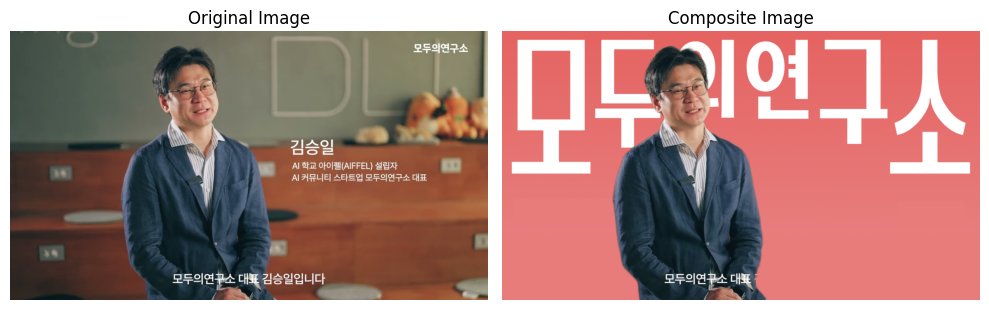

In [ ]:
import matplotlib.image as mpimg

# 이미지 파일 경로
aiffel_image_path = 'aiffel.jpg'
composite_image_path = 'composite_image.png'

# 이미지 읽기
aiffel_image = mpimg.imread(aiffel_image_path)
composite_image = mpimg.imread(composite_image_path)

# 서브플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 왼쪽에 aiffel.jpg 출력
axes[0].imshow(aiffel_image)
axes[0].axis('off')  # 축 제거
axes[0].set_title('Original Image')

# 오른쪽에 composite_image.png 출력
axes[1].imshow(composite_image)
axes[1].axis('off')  # 축 제거
axes[1].set_title('Composite Image')

# 서브플롯 간격 조절
plt.tight_layout()

# 그래프 출력
plt.show()

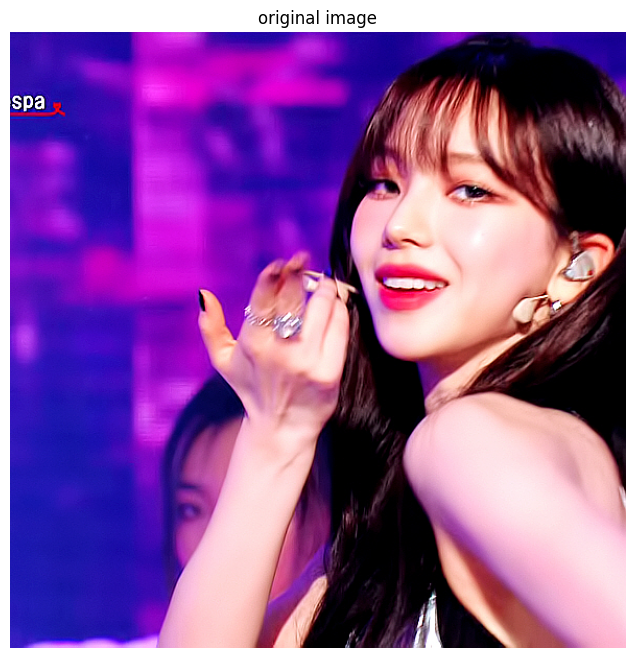

In [ ]:
# 디바이스 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 모델 로드
model = AutoModelForImageSegmentation.from_pretrained('briaai/RMBG-2.0', trust_remote_code=True)
torch.set_float32_matmul_precision(['high', 'highest'][0])
model.to(device)
model.eval()

# 이미지 경로 설정
input_image_path = '/content/karina.jpg'

# 원본 이미지 로드 및 표시
original_image = Image.open(input_image_path).convert('RGB')
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.title('original image')
plt.axis('off')
plt.show()

In [ ]:
# 이미지 전처리 함수
def transform_image(image):
    # 알파 채널 제거
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    image_size = (1024, 1024)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    return transform(image)

# 이미지 로드 및 전처리
image = Image.open(input_image_path)
input_images = transform_image(image).unsqueeze(0).to(device)

# 모델 추론
with torch.no_grad():
    preds = model(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()

# 마스크 생성 및 리사이즈
pred_pil = transforms.ToPILImage()(pred)
mask = pred_pil.resize(image.size, resample=Image.BILINEAR)


In [ ]:
# 마스크 생성 및 리사이즈
pred_pil = transforms.ToPILImage()(pred)
mask = pred_pil.resize(image.size, resample=Image.NEAREST)

# 마스크 이진화
mask_np = np.array(mask)
binary_mask = (mask_np > 0.5).astype(np.uint8) * 255
alpha_image = Image.fromarray(binary_mask, mode='L')

# 원본 이미지에 알파 채널 추가
image_rgba = image.convert('RGBA')
image_rgba.putalpha(alpha_image)

# 전경 이미지 추출 및 저장
foreground_np_save_path = '/content/foreground_image.png'
image_rgba.save(foreground_np_save_path, format='PNG')

# 저장 완료 메시지 출력
print(f"Foreground image saved to {foreground_np_save_path}")


Foreground image saved to /content/foreground_image.png


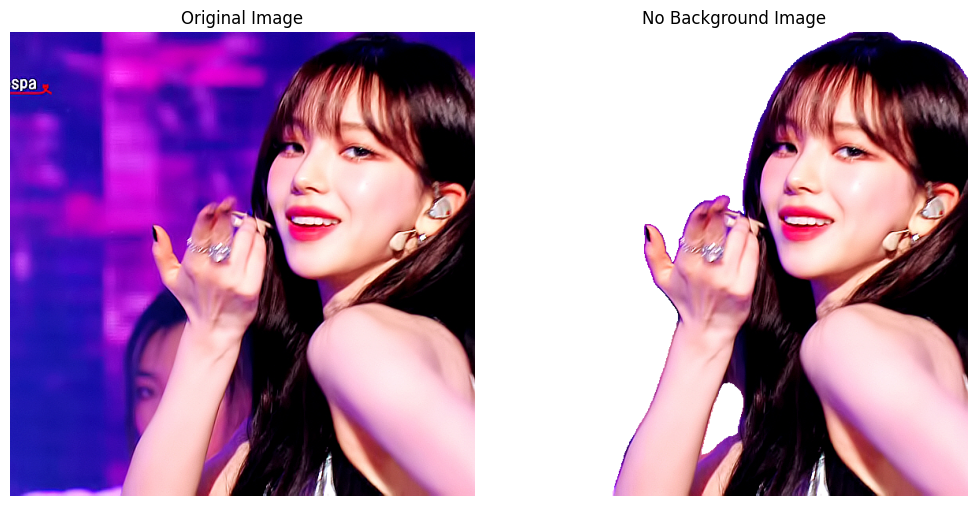

In [ ]:
import matplotlib.image as mpimg

# 이미지 파일 경로
original_image_path = 'karina.jpg'
tuned_image_path = 'foreground_image.png'

# 이미지 읽기
original_image = mpimg.imread(original_image_path)
tuned_image = mpimg.imread(tuned_image_path)

# 서브플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 왼쪽에 original.jpg 출력
axes[0].imshow(original_image)
axes[0].axis('off')  # 축 제거
axes[0].set_title('Original Image')

# 오른쪽에 composite_image.png 출력
axes[1].imshow(tuned_image)
axes[1].axis('off')  # 축 제거
axes[1].set_title('No Background Image')

# 서브플롯 간격 조절
plt.tight_layout()

# 그래프 출력
plt.show()